# Visualizing BData as Brain Volume

Author: Shuntaro C. Aoki

This notebook visualizes brain data extracted from BData in the form of brain volume (a three-dimensional array of voxels).

In [1]:
from itertools import product

import bdpy
import matplotlib.pyplot as plt
import nibabel
from nilearn import plotting
import numpy as np

%matplotlib inline

In [2]:
# Downloading data files if you don't have them.
!curl -L -o data/Subject1_T1wAligned.nii    https://ndownloader.figshare.com/files/14090069
!curl -L -o data/Subject1_SpaceTemplate.nii https://ndownloader.figshare.com/files/14090066
!curl -L -o data/Subject1.h5                https://ndownloader.figshare.com/files/15049646

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
100 48.0M  100 48.0M    0     0  2460k      0  0:00:19  0:00:19 --:--:-- 2613k     0  0:00:20  0:00:12  0:00:08 3532k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
100  800k  100  800k    0     0    99k      0  0:00:08  0:00:08 --:--:--  168k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
100  114M  100  114M    0     0  4926k      0  0:00:23  0:00:23 --:--:-- 6788k


## Converting BData into Brain Volume

First, we load BData and a template brain image. The template (`brain_space`) is a brain image in nii.gz format, defining the brain space used for brain data in BData. It's crucial to select a template that corresponds with the BData.

*Note: Future versions of bdpy may include an auto-exporting feature.*

In [3]:
# Load data
bdata = bdpy.BData('data/Subject1.h5')                         # fMRI data
brain_space = nibabel.load('data/Subject1_SpaceTemplate.nii')  # Template image of functional space

We then proceed to extract fMRI data and the XYZ coordinates of the voxels. The fMRI dataset (`brain_data`) is formatted as a 2D array of num_sample x num_voxels. The XYZ coordinates (`voxel_xyz`) are presented in a 2D array of 3 x num_voxels. Each column in voxel_xyz corresponds to the X, Y, and Z coordinates of a voxel, aligning with the respective column in brain_data.

In [4]:
# Get fMRI data and voxel coordinates
# Note that the example fMRI data contain only voxels in visual cortex
brain_data = bdata.select('VoxelData')
print('fMRI data size (sample x voxel):', brain_data.shape)

voxel_xyz = np.vstack([
    bdata.get_metadata('voxel_x', where='VoxelData'),
    bdata.get_metadata('voxel_y', where='VoxelData'),
    bdata.get_metadata('voxel_z', where='VoxelData'),
])
print('XYZ coordinates (3 x voxel):', voxel_xyz.shape)

fMRI data size (sample x voxel): (3450, 4466)
XYZ coordinates (3 x voxel): (3, 4466)


For demonstration purposes, we'll be visualizing the temporal mean of each voxel.

In [5]:
# Average fMRI data over time for visualization demo
brain_data_ave = np.mean(brain_data, axis=0)
print(brain_data_ave.shape)

(4466,)


Next, we convert the 2D brain data (`brain_data_ave`) into a 3D format (`brain_volume`), using the XYZ coordinates. The converted aligns with the template brain image (`brain_space`).

In [6]:
# Create a brain image for visualization demo

# XYZ to averaged fMRI data mapping
brain_data_table = {}
for i in range(brain_data_ave.shape[0]):
    value = brain_data_ave[i]
    x, y, z = voxel_xyz[0, i], voxel_xyz[1, i], voxel_xyz[2, i]
    brain_data_table.update({(x, y, z): value})

# Create a brain data array in the template functional space
brain_volume = np.zeros(brain_space.shape)  

for i, j, k in product(range(brain_space.shape[0]),
                       range(brain_space.shape[1]),
                       range(brain_space.shape[2])):
    
    # Voxel index --> coordinate
    x, y, z = brain_space.affine[:3, :3].dot([i, j, k]) + brain_space.affine[:3, 3]

    # Put averaged fMRI data into the brain data array based on voxel's XYZ coordinates
    if (x, y, z) in brain_data_table:
        brain_volume[i, j, k] = brain_data_table[(x, y, z)]

print(brain_volume.shape)

(64, 64, 50)


Now we can visualize the 3D brain data. Note that the sample BData only includes voxels within the visual cortex, hence only a portion of the brain will be displayed in the output image.

In [7]:
# Check orientation of the template brain space
nibabel.aff2axcodes(brain_space.affine)

('L', 'A', 'S')

The labels `('L', 'A', 'S')` indicate the orientation of the brain volume:

- 1st dim: Right to Left
- 2nd dim: Posterior to Anterior
- 3rd dim: Inferior to Superior

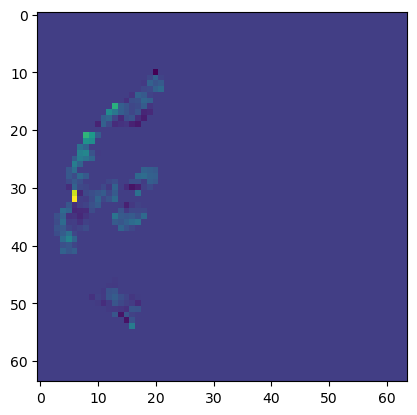

In [8]:
# Visualize the brain volume
plt.imshow(brain_volume[:, :, 25])  # Axial plane at the middle of the image
plt.show()

You can save the 3D brain image as nii.gz file as shown below.

In [9]:
# Save 
brain_volume_image = nibabel.Nifti1Image(brain_volume, brain_space.affine)
nibabel.save(brain_volume_image, 'data/Subject1_Averaged_fMRI.nii.gz')

## Visualizing Brain Volume on an Anatomical Brain Image

In this section, we will overlay the 3D brain volume (`brain_volume_image`) onto a separate high-resolution anatomical brain image.

In [10]:
# Open the anatomical brain image
brain_anatomy = nibabel.load('data/Subject1_T1wAligned.nii')   # Anatomical (T1w) image

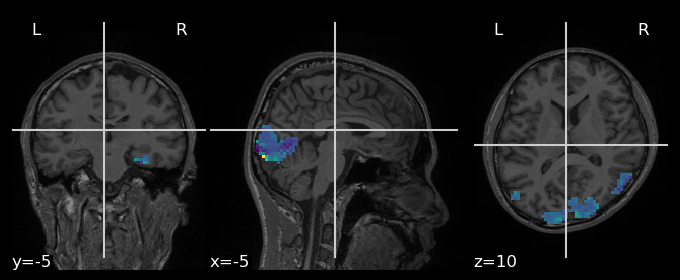

In [11]:
# Visualization (with nilearn)
display = plotting.plot_anat('data/Subject1_T1wAligned.nii', cut_coords=[-5, -5, 10])
display.add_overlay(brain_volume_image)